In [1]:
from sklearn.metrics import accuracy_score, classification_report
import torch
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import warnings
import re
from bs4 import BeautifulSoup
import os

warnings.filterwarnings("ignore", category=FutureWarning)

csv_file = "./data/collected_content.csv"
df = pd.read_csv(csv_file,encoding='gbk')
y = df.iloc[:,1]
df = df.dropna(subset=['Content', 'Class'])
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # 移除多余空格
    text = re.sub(r'[^a-zA-Z0-9\u4e00-\u9fa5 ]', '', text)  # 保留中英文和数字
    return text

df['Content'] = df['Content'].apply(clean_text)
def clean_html(content):
    soup = BeautifulSoup(content, "html.parser")
    return soup.get_text()

df['Content'] = df['Content'].apply(clean_html)
X = df['Content']
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 创建标签编码器
label_encoder = LabelEncoder()

# 将分类标签转换为数值
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print(label_encoder.classes_)  # 查看标签对应的数值编码
# 定义分类类别数量
num_classes = len(label_encoder.classes_)
# 分词和编码文本
def tokenize_data(texts, labels, tokenizer, max_length=512):
    inputs = tokenizer(texts.tolist(), max_length=max_length, padding=True, truncation=True, return_tensors="pt")
    return inputs, torch.tensor(labels, dtype=torch.long)
# 分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_inputs, train_labels = tokenize_data(X_train, y_train_encoded, tokenizer)
test_inputs, test_labels = tokenize_data(X_test, y_test_encoded, tokenizer)
train_dataset = TensorDataset(train_inputs['input_ids'], train_inputs['attention_mask'], train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

test_dataset = TensorDataset(test_inputs['input_ids'], test_inputs['attention_mask'], test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


['course' 'department' 'faculty' 'other' 'project' 'staff' 'student']


In [4]:
# 检查模型文件是否存在
model_path = "model_weights.pth"
optimizer_path = "optimizer_state.pth"

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
print(f"Using device: {device}")

# 判断是否已有模型文件
if os.path.exists(model_path):
    # 如果模型文件存在，加载模型和优化器
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    print("Model loaded successfully!")

    # 加载优化器（如果存在优化器文件）
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    if os.path.exists(optimizer_path):
        optimizer.load_state_dict(torch.load(optimizer_path))
        print("Optimizer loaded successfully!")
else:
    # 如果模型文件不存在，创建新模型并开始训练
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_classes)
    model.to(device)
    print("New model created for training.")

    # 定义优化器
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Optimizer loaded successfully!


In [5]:

for epoch in range(1):  # 训练1个epoch
    for batch in tqdm(train_dataloader):
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} completed. Loss: {loss.item()}")


100%|██████████| 208/208 [5:05:56<00:00, 88.25s/it]  

Epoch 1 completed. Loss: 0.02621440216898918


In [6]:
# 保存模型的 state_dict
torch.save(model.state_dict(), "model_weights.pth")
# 保存优化器的状态字典
torch.save(optimizer.state_dict(), "optimizer_state.pth")
# 保存整个模型对象（不推荐，但可以使用）
torch.save(model, "complete_model.pth")


In [7]:
from sklearn.metrics import accuracy_score, classification_report
import torch
from tqdm import tqdm

# 将模型切换到评估模式
model.eval()

# 初始化存储预测结果的列表
predictions = []
true_labels = []

# 使用测试集的 DataLoader
with torch.no_grad():  # 禁用梯度计算
    for batch in tqdm(test_dataloader):  # 使用测试集的 DataLoader
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2]

        # 前向传播
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        

        # 获取预测类别
        preds = torch.argmax(logits, dim=-1)

        # 存储结果
        predictions.extend(preds.cpu().numpy())  # 将结果从 GPU 移到 CPU
        true_labels.extend(labels.cpu().numpy())

# 计算准确率
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

# 计算分类报告（包括精确度、召回率、F1 得分）
report = classification_report(true_labels, predictions, output_dict=True)
print("Classification Report:\n", report)

# 将准确率写入文件
with open("model_accuracy.txt", "w") as f:
    f.write(f"Accuracy: {accuracy:.4f}\n")
    f.write("Classification Report:\n")
    f.write(str(report))


100%|██████████| 52/52 [23:41<00:00, 27.33s/it]

Accuracy: 0.9149
Classification Report:
 {'0': {'precision': 0.9702380952380952, 'recall': 0.8578947368421053, 'f1-score': 0.9106145251396648, 'support': 190.0}, '1': {'precision': 0.8620689655172413, 'recall': 1.0, 'f1-score': 0.9259259259259259, 'support': 25.0}, '2': {'precision': 0.9471153846153846, 'recall': 0.8418803418803419, 'f1-score': 0.8914027149321265, 'support': 234.0}, '3': {'precision': 0.9304677623261695, 'recall': 0.9722589167767504, 'f1-score': 0.9509043927648579, 'support': 757.0}, '4': {'precision': 0.9111111111111111, 'recall': 0.8367346938775511, 'f1-score': 0.8723404255319148, 'support': 98.0}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 35.0}, '6': {'precision': 0.8436657681940701, 'recall': 0.9842767295597484, 'f1-score': 0.9085631349782294, 'support': 318.0}, 'accuracy': 0.9149064574532287, 'macro avg': {'precision': 0.7806667267145817, 'recall': 0.7847207741337853, 'f1-score': 0.7799644456103885, 'support': 1657.0}, 'weighted avg': {'pr


d:\Python\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Python\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


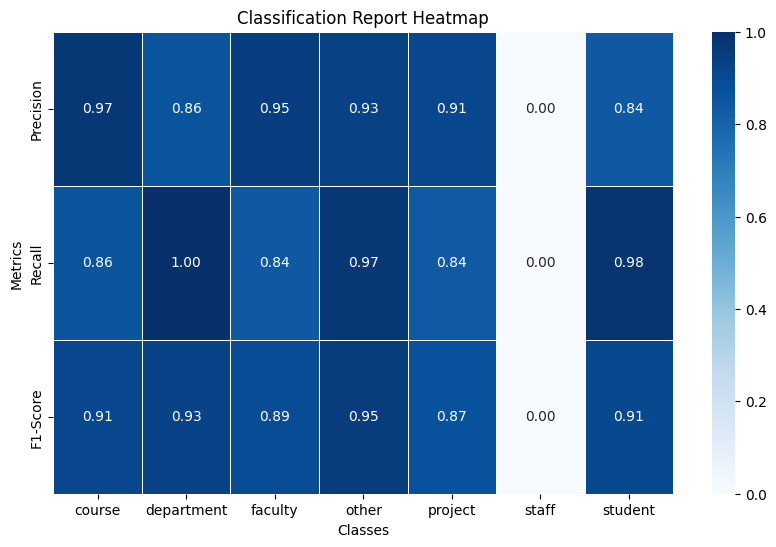

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 给定的分类结果字典
metrics = {
    '0': {'precision': 0.9702380952380952, 'recall': 0.8578947368421053, 'f1-score': 0.9106145251396648, 'support': 190.0},
    '1': {'precision': 0.8620689655172413, 'recall': 1.0, 'f1-score': 0.9259259259259259, 'support': 25.0},
    '2': {'precision': 0.9471153846153846, 'recall': 0.8418803418803419, 'f1-score': 0.8914027149321265, 'support': 234.0},
    '3': {'precision': 0.9304677623261695, 'recall': 0.9722589167767504, 'f1-score': 0.9509043927648579, 'support': 757.0},
    '4': {'precision': 0.9111111111111111, 'recall': 0.8367346938775511, 'f1-score': 0.8723404255319148, 'support': 98.0},
    '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 35.0},
    '6': {'precision': 0.8436657681940701, 'recall': 0.9842767295597484, 'f1-score': 0.9085631349782294, 'support': 318.0},
    'accuracy': 0.9149064574532287,
    'macro avg': {'precision': 0.7806667267145817, 'recall': 0.7847207741337853, 'f1-score': 0.7799644456103885, 'support': 1657.0},
    'weighted avg': {'precision': 0.8988899586533992, 'recall': 0.9149064574532287, 'f1-score': 0.9046470773488255, 'support': 1657.0}
}

# 类别标签
labels = ['course', 'department', 'faculty', 'other', 'project', 'staff', 'student']

# 从字典中提取各项指标
precision = [metrics[str(i)]['precision'] for i in range(7)]
recall = [metrics[str(i)]['recall'] for i in range(7)]
f1_score = [metrics[str(i)]['f1-score'] for i in range(7)]

# 将结果转换为 DataFrame
df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score
}, index=labels)

# 创建热图
plt.figure(figsize=(10, 6))
sns.heatmap(df.T, annot=True, cmap='Blues', cbar=True, fmt='.2f', linewidths=0.5)

# 添加标题和标签
plt.title("Classification Report Heatmap")
plt.xlabel("Classes")
plt.ylabel("Metrics")
plt.show()


In [9]:
df

,Precision,Recall,F1-Score
course,0.970238,0.857895,0.910615
department,0.862069,1.000000,0.925926
faculty,0.947115,0.841880,0.891403
other,0.930468,0.972259,0.950904
project,0.911111,0.836735,0.872340
staff,0.000000,0.000000,0.000000
student,0.843666,0.984277,0.908563


In [29]:
csv_file = "./data/collected_content.csv"
df = pd.read_csv(csv_file,encoding='gbk')

In [31]:
df[df['Class']=='staff']

,University,Class,Content,Filename
8211,cornell,staff,MIME-Version: 1.0 Server: CERN/3.0 Date: Wedne...,http:^^www.cs.cornell.edu^Info^People^frank^fr...
8212,cornell,staff,MIME-Version: 1.0 Server: CERN/3.0 Date: Sunda...,http:^^simon.cs.cornell.edu^Info^People^vogels^
8213,cornell,staff,MIME-Version: 1.0 Server: CERN/3.0 Date: Wedne...,http:^^www.cs.cornell.edu^Info^People^csun^sun...
8214,cornell,staff,MIME-Version: 1.0 Server: CERN/3.0 Date: Wedne...,http:^^www.cs.cornell.edu^Info^Department^Annu...
8215,cornell,staff,MIME-Version: 1.0 Server: CERN/3.0 Date: Wedne...,http:^^www.cs.cornell.edu^Info^People^jackson^...
...,...,...,...,...
8343,wisconsin,staff,Date: Thu 07 Nov 1996 19:10:11 GMT Server: NC...,http:^^www.cs.wisc.edu^~naim^naim.html
8344,wisconsin,staff,Date: Fri 15 Nov 1996 00:17:56 GMT Server: NC...,http:^^www.cs.wisc.edu^~curt^curt.html
8345,texas,staff,MIME-Version: 1.0 Server: CERN/3.0 Date: Monda...,http:^^www.cs.utexas.edu^users^pkn^
8346,texas,staff,MIME-Version: 1.0 Server: CERN/3.0 Date: Monda...,http:^^www.cs.utexas.edu^users^souther^


In [33]:
len(test_dataset)

1657

In [32]:
len(train_dataset)

6625

In [26]:
input_ids = train_dataset[0][0].unsqueeze(0)
attention_mask = train_dataset[0][1].unsqueeze(0)
labels = train_dataset[0][2]

# 前向传播
outputs = model(input_ids, attention_mask=attention_mask)
logits = outputs.logits


# 获取预测类别
preds = torch.argmax(logits, dim=-1)

preds

tensor([3])

In [27]:
labels

tensor(3)